In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
from matplotlib_venn import venn3, venn3_circles
#import matplotlib_venn 


import re
import logging
import itertools
import unicodedata
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
# import contractions

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from IPython.display import Markdown as md

from wordsegment import load, segment
load()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print("Check for missing values in Train dataset")
null_check=train_data.isnull().sum()
print(null_check)
#print("Check for missing values in Test dataset")
#null_check=test.isnull().sum()
#print(null_check)
print("filling NA with \"unknown\"")
train_data["comment_text"].fillna("unknown", inplace=True)
#test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
filling NA with "unknown"


In [5]:
for i in ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']:
    print("{} :".format(i.upper()))
    print(train_data.loc[train_data[i]==1, 'comment_text'].sample().values, "\n")

TOXIC :
['npov\nYou yell at me about NPOV, but your the fucking sock puppet.'] 

SEVERE_TOXIC :
['Well fuck you too then asshole \n\nBe a dick.'] 

OBSCENE :
['"\n\n Hey What\'s Up \n\nHey Pink Floyd guy,\nI started editing on Wikipedia just to keep my mind occupied, I\'m going through deep shit, when I started reading the factual errors and the sick shit like mentioning mortality, dying and suicide on the prognosis section of anorexia nervosa, I started contributing out of altruism. \n\nWikipedia occupies the first spot on most searches, for self righteous, incompetent dickheads ( can I say that or am I violating WP:Dickhead?) to claim ownership and disseminate bullshit is wrong, it makes Wikipedia look bad and more importantly people are getting bullshit information. \nThere is one particular individual who seems to clamor for attention, his 15 minutes of fame went to his head. All the articles he created are one sentence to a paragraph long. To up his ""look at me"" count he merely 

In [6]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [7]:
## plots for EDA :

plt.style.use("seaborn-pastel")
def category_count(df):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean']
    plot_data = df[categories].sum()

    plt.figure(figsize=(10,5))
    plt.title("counting records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return

def category_percentage(df):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean']
    plot_data = df[categories].mean()*100

    plt.figure(figsize=(10,5))
    plt.title("percentage records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return



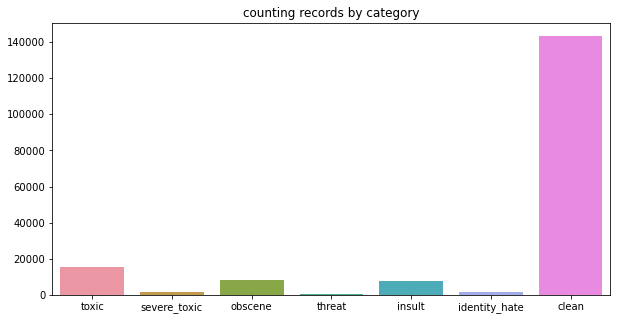

In [8]:
category_count(train_data)

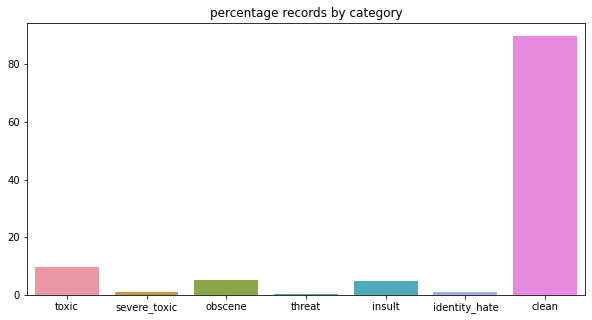

In [9]:
category_percentage(train_data)

In [10]:
train_data.shape

(159571, 9)

In [11]:
def text_length_across_classes(df):
    df['comment_length'] = df['comment_text'].apply(lambda x : len(x.split()))
    
    median_text_len = []
    mean_text_len = []
    min_text_len = []
    max_text_len = []
    max_distinct_tokens = []
    
    for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
        mean_text_len.append(df[df[i]==1]['comment_length'].mean())  
        min_text_len.append(df[df[i]==1]['comment_length'].min())  
        max_text_len.append(df[df[i]==1]['comment_length'].max())  
        median_text_len.append(df[df[i]==1]['comment_length'].median())  
        df['distinct_tokens'] = df['comment_text'].apply(lambda x : len(set(x.split())))
        max_distinct_tokens.append(df[df[i]==1]['distinct_tokens'].max())
    #clean column    
    mean_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].mean())
    min_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].min())
    max_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].max())
    median_text_len.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['comment_length'].median())
    max_distinct_tokens.append(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]['distinct_tokens'].max())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.barplot(ax=axes[0,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=median_text_len)
    axes[0,0].set_title('median text length')
    sns.barplot(ax=axes[0,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=min_text_len)
    axes[0,1].set_title('minimum text length')
    sns.barplot(ax=axes[1,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_text_len)
    axes[1,0].set_title('max text length')
    sns.barplot(ax=axes[1,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean'], 
                y=max_distinct_tokens)
    axes[1,1].set_title('max distinct tokens')

    fig.suptitle('text length statistics')
    plt.show()
    
    return 



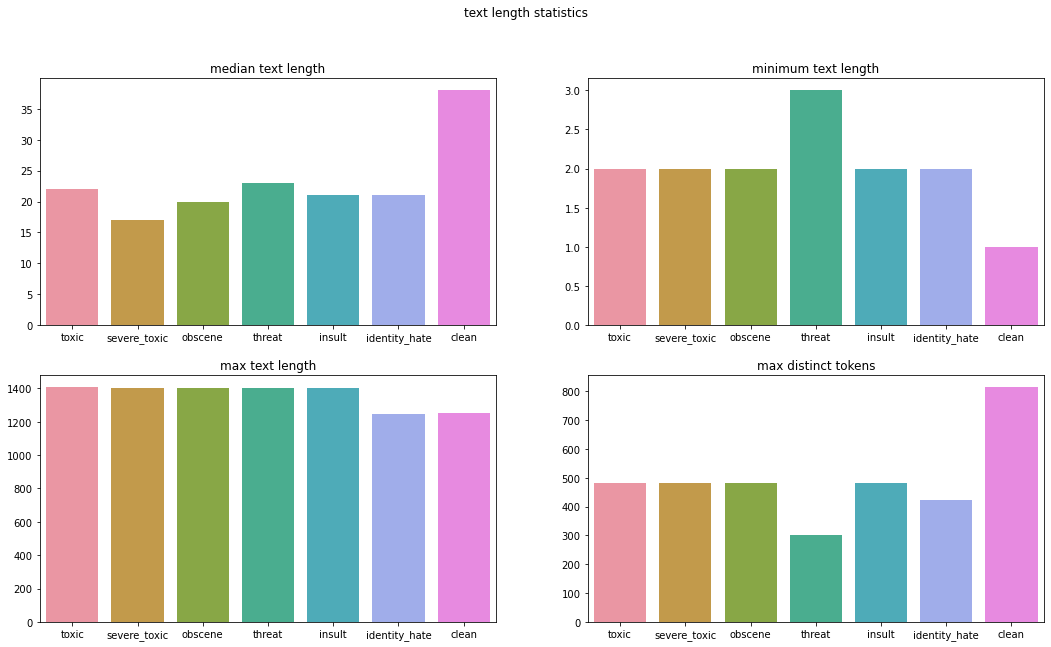

In [12]:
text_length_across_classes(train_data)

In [13]:
def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return 

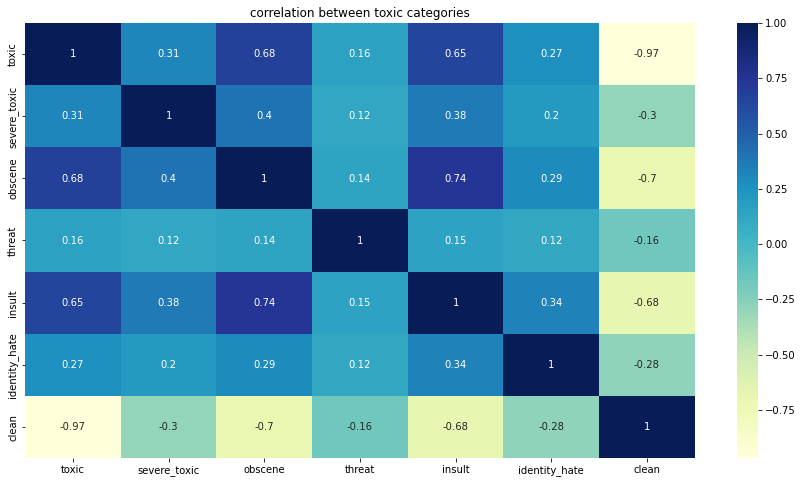

In [14]:
corr_between_labels(train_data[[ 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate','clean']])

In [15]:
## Gram statistics
def gram_analysis(data,gram):
    stop_words_set = set(stopwords.words('english'))
    tokens=[t for t in data.lower().split(" ") if t!="" if t not in stop_words_set]
    ngrams=zip(*[tokens[i:] for i in range(gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].sample(200).values)
    
    toks = gram_analysis(category_text, gram)
   
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
  
    tok_freq.columns = ['token','frequency']
   
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    
    plt.figure(figsize=(10,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return 


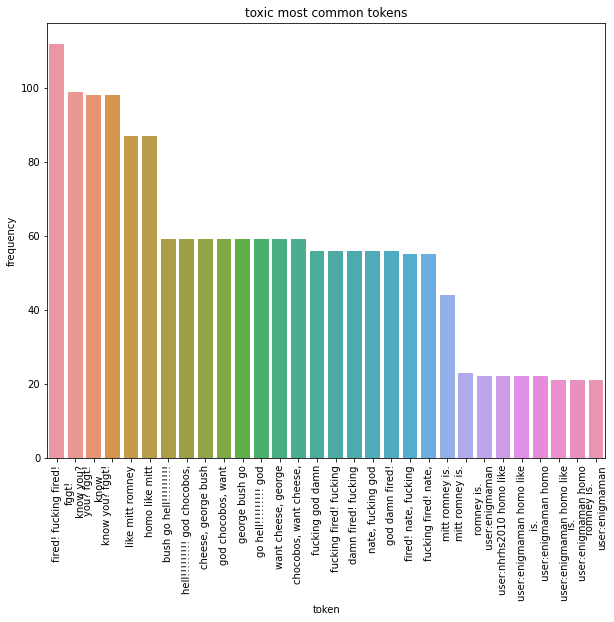

In [16]:
gram_freq(train_data,3,'toxic','comment_text')

In [17]:
def generate_wordclouds(df, text_col, categ_col):
    df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    if categ_col=='all_toxic':
        category_text = df[df['clean']!=1][text_col].values
    else:
        category_text = df[df[categ_col]==1][text_col].values
               
    plt.figure(figsize=(15,8))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    wc.generate(" ".join(category_text))
    plt.title("{} word cloud".format(categ_col), fontsize=20)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    
    plt.show()
    
    return 

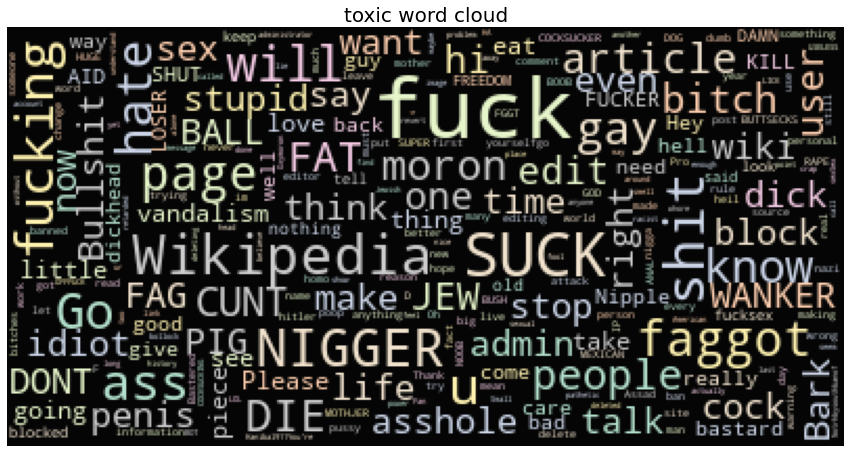

In [18]:
generate_wordclouds(train_data,'comment_text','toxic')

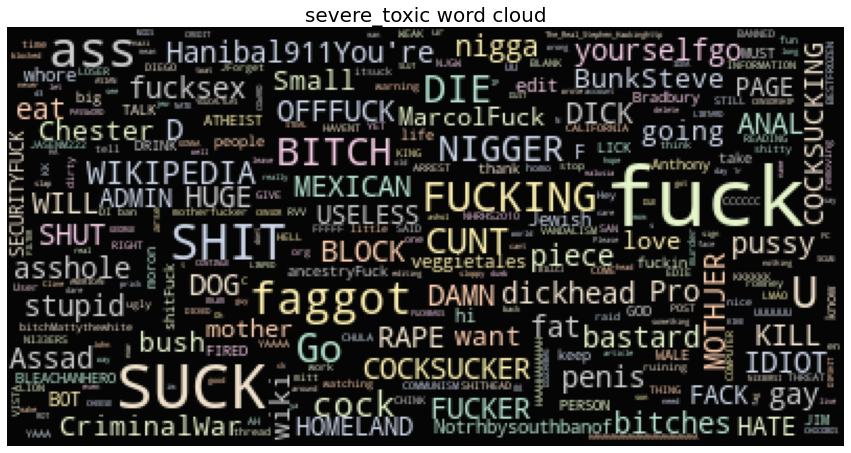

In [19]:
generate_wordclouds(train_data,'comment_text','severe_toxic')

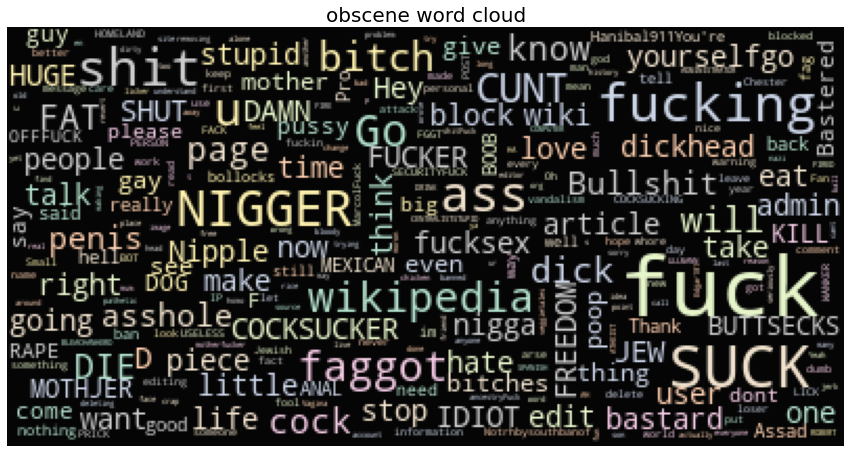

In [20]:
generate_wordclouds(train_data,'comment_text','obscene')

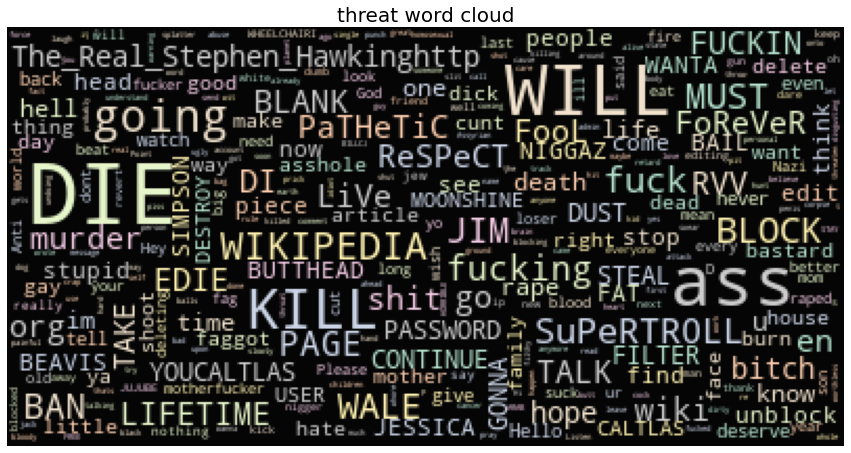

In [21]:
generate_wordclouds(train_data,'comment_text','threat')

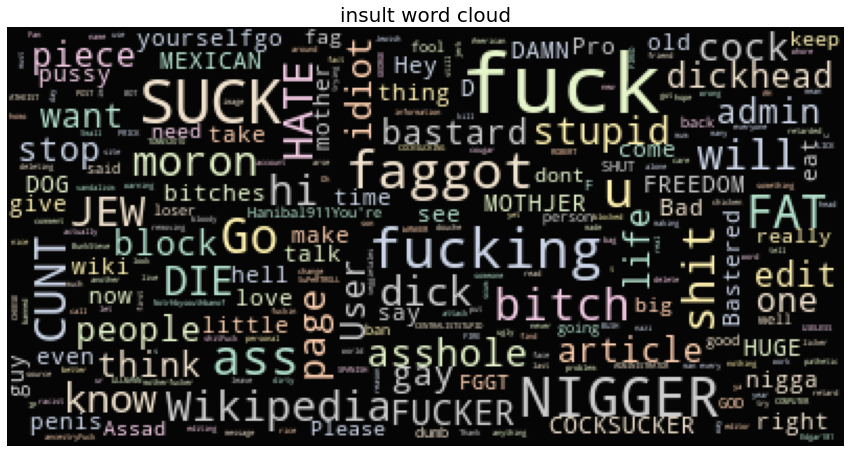

In [22]:
generate_wordclouds(train_data,'comment_text','insult')

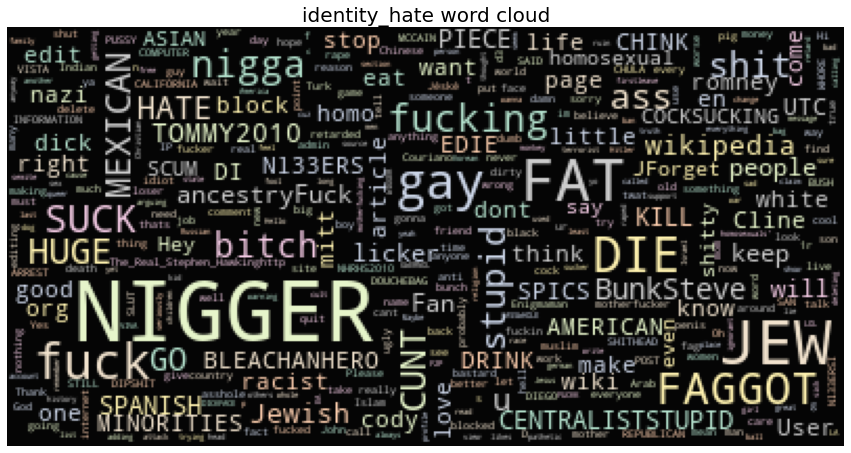

In [23]:
generate_wordclouds(train_data,'comment_text','identity_hate')

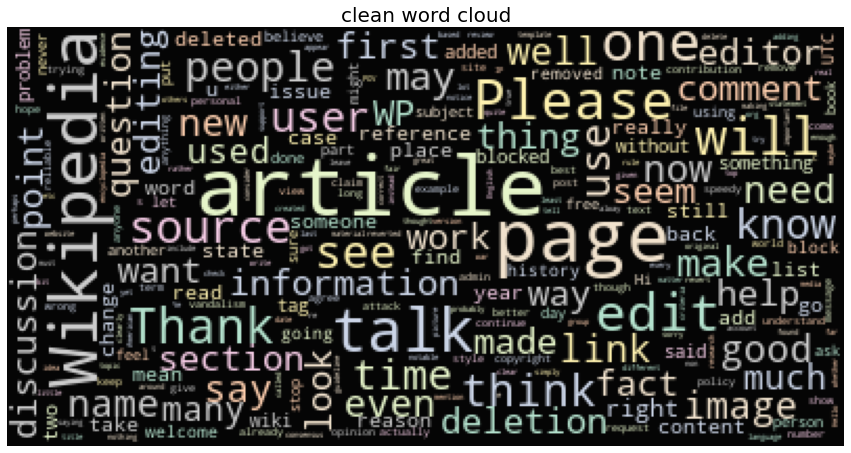

In [24]:
generate_wordclouds(train_data,'comment_text','clean')

In [25]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean', 'comment_length',
       'distinct_tokens'],
      dtype='object')

In [26]:
def venn_(df):
    figure, axes = plt.subplots(2,2,figsize=(20,20))
    toxic = set(df[df['toxic']==1].index)
    severe_toxic = set(df[df['severe_toxic']==1].index)
    obscene = set(df[df['obscene']==1].index)
    threat = set(df[df['threat']==1].index)
    insult = set(df[df['insult']==1].index)
    identity_hate = set(df[df['identity_hate']==1].index)
    clean = set(df[df['clean']==1].index)

    v1 = venn3([toxic, severe_toxic, obscene],
          set_labels=('Toxic','Severe toxic','Obscene'), set_colors=('#a5e6ff', '#3c8492','#9D8189'), ax=axes[0][0])
    for text in v1.set_labels:
        text.set_fontsize(22)
    v2 = venn3([threat, insult, identity_hate],
          set_labels=('Threat','Insult','Identity hate'), set_colors=('#e196ce', '#F29CB7','#3c81a9'), ax=axes[0][1])
    for text in v2.set_labels:
        text.set_fontsize(22)
    v3 = venn3([toxic, insult, obscene],
          set_labels=('Toxic','Insult','Obscene'), set_colors=('#a5e6ff', '#F29CB7','#9D8189'), ax=axes[1][0])
    for text in v3.set_labels:
        text.set_fontsize(22)
    v4 = venn3([threat, identity_hate, obscene],
          set_labels=('Threat','Identity hate','Obscene'), set_colors=('#e196ce', '#3c81a9','#9D8189'), ax=axes[1][1])
    for text in v4.set_labels:
        text.set_fontsize(22)
    plt.show()
    
    # deleting used variables
    del toxic
    del severe_toxic
    del obscene
    del threat
    del insult
    del identity_hate
    del clean
    
    return



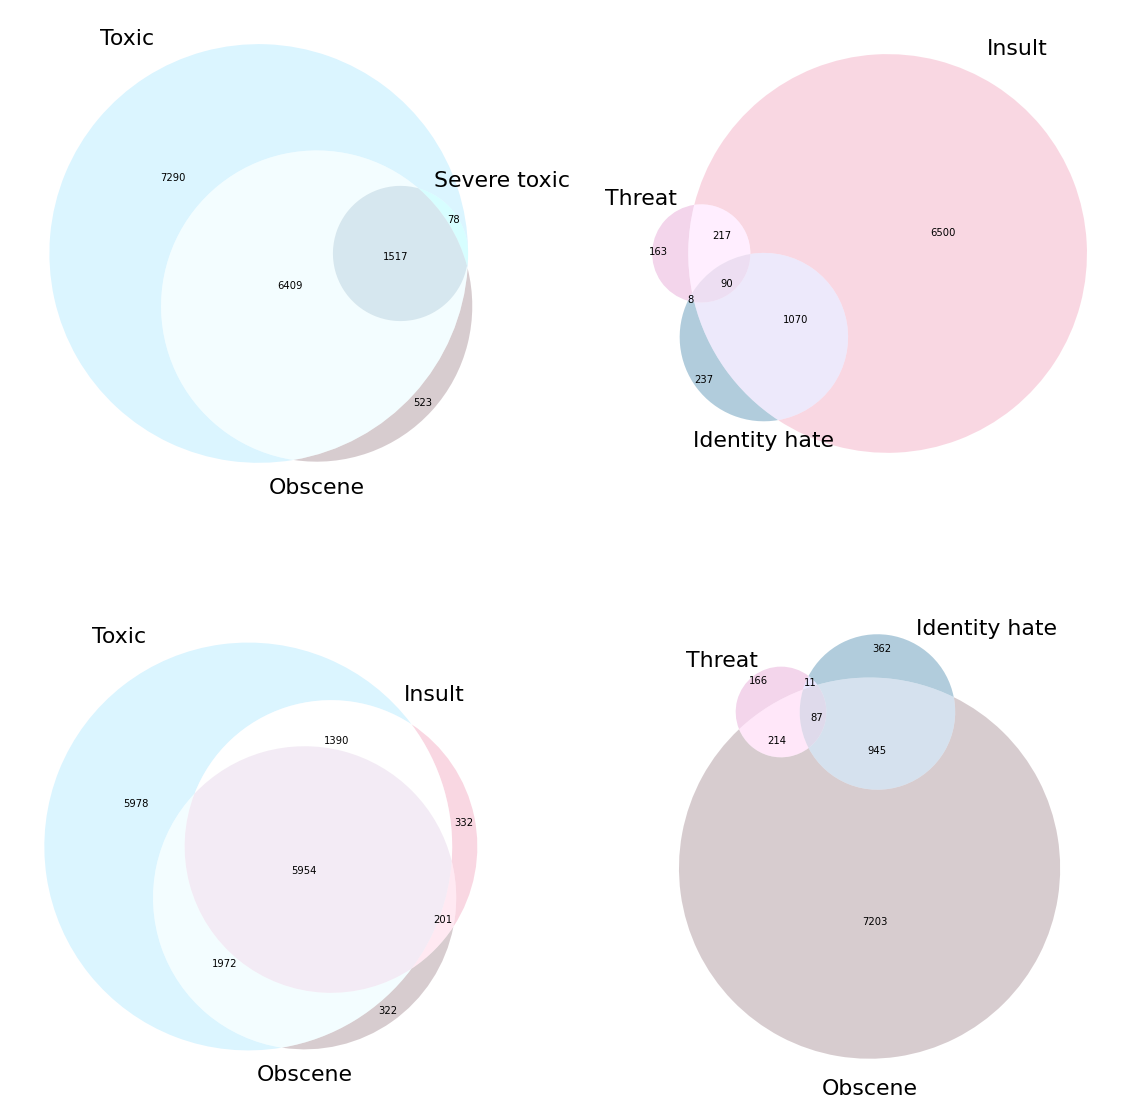

In [27]:
venn_(train_data)

In [28]:
def meta_data_analysis(df, text_col):
    meta_df = pd.DataFrame()
    meta_df['punctuations'] = df[text_col].apply(lambda x : len([a for a in str(x) if a in string.punctuation]))
    meta_df['hashtags'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("#")]))
    meta_df['usernames'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith("@")]))
    meta_df['stop_words'] = df[text_col].apply(lambda x : len([a for a in x.lower().split() if a in STOPWORDS]))
    meta_df['upper_case_words'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.isupper()]))
    meta_df['urls'] = df[text_col].apply(lambda x : len([a for a in x.split() if a.startswith(tuple(['http', 'www']))]))
    meta_df['word_count'] = df[text_col].apply(lambda x : len(x.split()))
    meta_df['distinct_word_count'] = df[text_col].apply(lambda x : len(set(x.split())))
    meta_df['clean'] = df['clean'].copy()
    
    return meta_df

analysis_df = meta_data_analysis(train_data[train_data['toxic']==1],'comment_text')

In [29]:
analysis_df.head()

,punctuations,hashtags,usernames,stop_words,upper_case_words,urls,word_count,distinct_word_count,clean
6,0,0,0,4,8,0,8,8,0
12,24,0,1,22,6,0,53,50,0
16,5,0,0,3,0,0,10,10,0
42,28,0,0,54,3,0,117,88,0
43,2,0,0,3,8,0,8,8,0


In [30]:
analysis_df['distinct_word_count'].max()

480

In [31]:
## Text cleaning

import re

class TextCleaningUtils:
    '''
        This class contains implementations of various text cleaning operations (Static Methods)
    '''

    cleaning_regex_map = {
        'web_links': r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+',
#         'special_chars': r'[^a-zA-Z0-9\s\.,!?;:]+',
        'special_chars': r'[^a-zA-Z\s\.,!?;:]+',  ## removing nums
        'redundant_spaces': r'\s\s+',
        'redundant_newlines': r'[\r|\n|\r\n]+',
        'twitter_handles': r'[#@]\S+',
        'punctuations': r'[\.,!?;:]+'
    }
    
    def expand_abbreviations(text):
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"We're", "We are", text)
        text = re.sub(r"That's", "That is", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"they're", "they are", text)
        text = re.sub(r"Can't", "Cannot", text)
        text = re.sub(r"wasn't", "was not", text)
        text = re.sub(r"don\x89Ûªt", "do not", text)
        text= re.sub(r"aren't", "are not", text)
        text = re.sub(r"isn't", "is not", text)
        text = re.sub(r"What's", "What is", text)
        text = re.sub(r"haven't", "have not", text)
        text = re.sub(r"hasn't", "has not", text)
        text = re.sub(r"There's", "There is", text)
        text = re.sub(r"He's", "He is", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"You're", "You are", text)
        text = re.sub(r"I'M", "I am", text)
        text = re.sub(r"shouldn't", "should not", text)
        text = re.sub(r"wouldn't", "would not", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"i'm", "I am", text)
        text = re.sub(r"I\x89Ûªm", "I am", text)
        text = re.sub(r"I'm", "I am", text)
        text = re.sub(r"Isn't", "is not", text)
        text = re.sub(r"Here's", "Here is", text)
        text = re.sub(r"you've", "you have", text)
        text = re.sub(r"you\x89Ûªve", "you have", text)
        text = re.sub(r"we're", "we are", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"we've", "we have", text)
        text = re.sub(r"it\x89Ûªs", "it is", text)
        text = re.sub(r"doesn\x89Ûªt", "does not", text)
        text = re.sub(r"It\x89Ûªs", "It is", text)
        text = re.sub(r"Here\x89Ûªs", "Here is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"I\x89Ûªve", "I have", text)
        text = re.sub(r"y'all", "you all", text)
        text = re.sub(r"can\x89Ûªt", "cannot", text)
        text = re.sub(r"would've", "would have", text)
        text = re.sub(r"it'll", "it will", text)
        text = re.sub(r"we'll", "we will", text)
        text = re.sub(r"wouldn\x89Ûªt", "would not", text)
        text = re.sub(r"We've", "We have", text)
        text = re.sub(r"he'll", "he will", text)
        text = re.sub(r"Y'all", "You all", text)
        text = re.sub(r"Weren't", "Were not", text)
        text = re.sub(r"Didn't", "Did not", text)
        text = re.sub(r"they'll", "they will", text)
        text = re.sub(r"DON'T", "DO NOT", text)
        text = re.sub(r"That\x89Ûªs", "That is", text)
        text = re.sub(r"they've", "they have", text)
        text = re.sub(r"they'd", "they would", text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"should've", "should have", text)
        text = re.sub(r"You\x89Ûªre", "You are", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"Don\x89Ûªt", "Do not", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"weren't", "were not", text)
        text = re.sub(r"They're", "They are", text)
        text = re.sub(r"Can\x89Ûªt", "Cannot", text)
        text = re.sub(r"you\x89Ûªll", "you will", text)
        text = re.sub(r"I\x89Ûªd", "I would", text)
        text = re.sub(r"let's", "let us", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i've", "I have", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"i'll", "I will", text)
        text = re.sub(r"doesn't", "does not",text)
        text = re.sub(r"i'd", "I would", text)
        text = re.sub(r"didn't", "did not", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"you'll", "you will", text)
        text = re.sub(r"I've", "I have", text)
        text = re.sub(r"Don't", "do not", text)
        text = re.sub(r"I'll", "I will", text)
        text = re.sub(r"I'd", "I would", text)
        text = re.sub(r"Let's", "Let us", text)
        text = re.sub(r"you'd", "You would", text)
        text = re.sub(r"It's", "It is", text)
        text = re.sub(r"Ain't", "am not", text)
        text = re.sub(r"Haven't", "Have not", text)
        text = re.sub(r"Hadn't", "Had not", text)
        text = re.sub(r"Could've", "Could have", text)
        text = re.sub(r"youve", "you have", text)  
        text = re.sub(r"donå«t", "do not", text)  

        return text
    
    def remove_emojis(text):
        emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text=emoji_clean.sub(r'',text)
        url_clean= re.compile(r"https://\S+|www\.\S+")
        text=url_clean.sub(r'',text)
        return text
    
#     def remove_punctuations(text):
#         punct_tag=re.compile(r'[^\w\s]')
#         text=punct_tag.sub(r'',text)
#         return text

    @staticmethod
    def clean_text_from_regex(text, text_clean_regex):
        '''
            Follow a particular cleaning expression, provided
            as an input by an user to clean the text.
        '''

        text = text_clean_regex.sub(' ', text).strip()
        return text

    @staticmethod
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_special_chars(text):
        '''
            Replace any special character provided as default,
            which is present in the text with space
        '''

        special_chars_regex = re.compile(TextCleaningUtils.cleaning_regex_map['special_chars'])
        text = TextCleaningUtils.clean_text_from_regex(text, special_chars_regex)
        return text

    @staticmethod
    def remove_redundant_spaces(text):
        '''
            Remove any redundant space provided as default,
            that is present in the text.
        '''

        redundant_spaces_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_spaces'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_spaces_regex)
        return text

    @staticmethod
    def remove_web_links(text):
        '''
            Removes any web link that follows a particular default expression,
            present in the text.
        '''

        web_links_regex = re.compile(TextCleaningUtils.cleaning_regex_map['web_links'])
        text = TextCleaningUtils.clean_text_from_regex(text, web_links_regex)
        return text

    @staticmethod
    def remove_twitter_handles(text):
        '''
            Removes any twitter handle present in the text.
        '''

        twitter_handles_regex = re.compile(TextCleaningUtils.cleaning_regex_map['twitter_handles'])
        text = TextCleaningUtils.clean_text_from_regex(text, twitter_handles_regex)
        return text

    @staticmethod
    def remove_redundant_newlines(text):
        '''
            Removes any redundant new line present in the text.
        '''

        redundant_newlines_regex = re.compile(
            TextCleaningUtils.cleaning_regex_map['redundant_newlines'])
        text = TextCleaningUtils.clean_text_from_regex(text, redundant_newlines_regex)
        return text

    @staticmethod
    def remove_punctuations(text):
        '''
            Removes any punctuation that follows the default expression, in the text.
        '''

        remove_punctuations_regex = re.compile(TextCleaningUtils.cleaning_regex_map['punctuations'])
        text = TextCleaningUtils.clean_text_from_regex(text, remove_punctuations_regex)
        return text

    @staticmethod
    def remove_exaggerated_words(text):
        '''
            Removes any exaggerated word present in the text.
        '''

        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))

    @staticmethod
    def replace_multiple_chars(text):
        '''
            Replaces multiple characters present in the text.
        '''

        char_list = ['.', '?', '!', '#', '$', '/', '@', '*', '(', ')', '+']
        final_text = ''
        for i in char_list:
            if i in text:
                pattern = "\\" + i + '{2,}'
                repl_str = i.replace("\\", "")
                text = re.sub(pattern, repl_str, text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def replace_sign(text):
        '''
            Replaces any sign with words like & with 'and', in the text.
        '''
        sign_list = {'&': ' and ', '/': ' or ', '\xa0': ' '}
        final_text = ''
        for i in sign_list:
            if i in text:
                text = re.sub(i, sign_list[i], text)
                final_text = ' '.join(text.split())
        return final_text

    @staticmethod
    def remove_accented_char(text):
        text = unicodedata.normalize('NFD', text) \
            .encode('ascii', 'ignore') \
            .decode("utf-8")
        return str(text)

    @staticmethod
    def replace_characters(text, replace_map):
        '''
            Replaces any character custom provided by an user.
        '''

        for char, replace_val in replace_map.items():
            text = text.replace(char, replace_val)
        return text
    
def clean_data(df,col_to_clean):
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.expand_abbreviations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_emojis)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_special_chars)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_spaces)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_punctuations)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_exaggerated_words)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_redundant_newlines)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_twitter_handles)
    df[col_to_clean] = df[col_to_clean].apply(TextCleaningUtils.remove_web_links)
    df[col_to_clean] = df[col_to_clean].astype(str)
    df[col_to_clean] = df[col_to_clean].str.lower()
    
    return df

In [32]:
train_data = clean_data(train_data, 'comment_text')

In [33]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment_length,distinct_tokens
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1,43,41
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0,1,17,17
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0,1,42,39
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,1,113,82
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0,1,13,13


In [34]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print('checking')
print(list(train_data[train_data[label_cols[0]]==1].comment_text)[0])
print(list(train_data[train_data[label_cols[0]]==1].comment_text)[1])
print(list(train_data[train_data[label_cols[0]]==1].comment_text)[2])

checking
cocksucker before you piss around on my work
hey  what is it  talk   what is it  an exclusive group of some wp talibans who are good at destroying  self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp  ask sityush to clean up his behavior than issue me nonsensical warnings
bye  do not look  come or think of comming back  tosser


In [35]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
from collections import Counter

def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech


print('BEFORE:\n',list(train_data[train_data[label_cols[0]]==1].comment_text)[1],'\n')

cleaned = re.sub('\W+',' ',list(train_data[train_data[label_cols[0]]==1].comment_text)[1]) 
print('AFTER clearing non-words:\n',cleaned,'\n')

tokenized = word_tokenize(cleaned)
print('AFTER tokenizing:\n',tokenized,'\n')

filtered_stopwords = [w for w in tokenized if not w in stopwords.words('english')]
print('AFTER removing stopwords:\n',filtered_stopwords)

lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(i,get_part_of_speech(i)) for i in filtered_stopwords]
print('AFTER lemmatizing:\n',lemmatized)

regroup = " ".join(lemmatized)
print('AFTER regrouping:\n',regroup)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aritr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BEFORE:
 hey  what is it  talk   what is it  an exclusive group of some wp talibans who are good at destroying  self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp  ask sityush to clean up his behavior than issue me nonsensical warnings 

AFTER clearing non-words:
 hey what is it talk what is it an exclusive group of some wp talibans who are good at destroying self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings 

AFTER tokenizing:
 ['hey', 'what', 'is', 'it', 'talk', 'what', 'is', 'it', 'an', 'exclusive', 'group', 'of', 'some', 'wp', 'talibans', 'who', 'are', 'good', 'at', 'destroying', 'self', 'appointed', 'purist', 'who', 'gang', 'up', 'any', 'one', 'who', 'asks', 'them', 'questions', 'abt', 'their', 'anti', 'social', 'and', 'destructive', 'non', 'contribution', 'at

In [36]:
# lemmatizer = WordNetLemmatizer()

# def text_processing(text_list):
#     processed_text = []
#     for text in text_list:
#         cleaned = re.sub('\W+',' ',text)
#         lowered = cleaned.lower()
#         tokenized = word_tokenize(lowered)
#         filtered_stopwords = [w for w in tokenized if not w in stopwords.words('english')]
#         lemmatized = [lemmatizer.lemmatize(i,get_part_of_speech(i)) for i in filtered_stopwords]
#         processed_text.append(" ".join(lemmatized))
#     return processed_text



In [37]:
#processed_text = text_processing(train_data['comment_text'])
#test_processed_text = text_processing(df_test['comment_text'])

In [38]:
#split into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_data, random_state=42, test_size=0.30, shuffle=True)

In [39]:
#processed_text_tr = text_processing(train['comment_text'])
#processed_text_test = text_processing(test['comment_text'])

In [40]:
train.head(),train.columns

(                      id                                       comment_text  \
 54568   91da4b4b95fe5e2d  conflict of interest note by your user name  i...   
 3786    0a1df25805d6d2e7  update  actually  i changed this to something ...   
 22938   3c9e75d2b8dcf720  mrca article sniperz  thanks for your comments...   
 137856  e1b03f4baf9d58ce  arguing that bart and caltrain should get more...   
 143038  fcdf5d299437f2a9  blocked hi  i blocked you for hours for being ...   
 
         toxic  severe_toxic  obscene  threat  insult  identity_hate  clean  \
 54568       0             0        0       0       0              0      1   
 3786        0             0        0       0       0              0      1   
 22938       0             0        0       0       0              0      1   
 137856      0             0        0       0       0              0      1   
 143038      0             0        0       0       0              0      1   
 
         comment_length  distinct_tokens  

In [41]:
train_text = train['comment_text'].tolist()
test_text = test['comment_text'].tolist()

In [42]:
#divide into train and test
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','comment_text','comment_length',
        'distinct_tokens'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['id','comment_text','comment_length',
        'distinct_tokens'], axis=1)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']
pred_labels = []
for category in label_cols:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    pred_labels.append(prediction)
    print('F1-score is {}'.format(f1_score(test[category], prediction,average = 'weighted')))
    #f1_score(y_true, y_pred, average='weighted')
    print("\n")

**Processing toxic comments...**
F1-score is 0.9245853033803839


**Processing severe_toxic comments...**
F1-score is 0.9859487667655631


**Processing obscene comments...**
F1-score is 0.9550333823417364


**Processing threat comments...**
F1-score is 0.9957925449849304


**Processing insult comments...**
F1-score is 0.9486141696042013


**Processing identity_hate comments...**
F1-score is 0.9869848283889759


**Processing clean comments...**
F1-score is 0.9212360219402398




In [44]:
sum(pred_labels[4])

591

In [45]:
cc = pd.DataFrame(columns=label_cols)
for i,j in enumerate(label_cols):
    cc[j] = pred_labels[i]
    

In [46]:
cc.tail(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
47862,0,0,0,0,0,0,1
47863,0,0,0,0,0,0,1
47864,0,0,0,0,0,0,1
47865,0,0,0,0,0,0,1
47866,0,0,0,0,0,0,1
47867,0,0,0,0,0,0,1
47868,0,0,0,0,0,0,1
47869,0,0,0,0,0,0,1
47870,0,0,0,0,0,0,1
47871,0,0,0,0,0,0,1


In [47]:
test.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment_length,distinct_tokens
93213,f93e15795f185ad3,re unblock thank you very much is there any c...,0,0,0,0,0,0,1,35,33
159220,fa739360ef0d3ff8,carternut shall never be banned alf,0,0,0,0,0,0,1,5,5
136620,dadd33f36a539c42,please do not exchange uk spelling with us spe...,0,0,0,0,0,0,1,13,13
58667,9d22cb89f2d62fc0,i just posted on your talk about this too fun...,0,0,0,0,0,0,1,60,51
129047,b223a04e2b3782b0,i removed them pika,0,0,0,0,0,0,1,6,5
61999,a5e8811002c2e965,his documented emotional involvements with boy...,0,0,0,0,0,0,1,209,151
116777,703c79bd1ef1f61d,rename i do not know if it has been done or pr...,0,0,0,0,0,0,1,35,32
134143,cd618fa54e2da21d,just random nazi soldiers,0,0,0,0,0,0,1,4,4
81360,d99ec9d910520101,add comments below this line,0,0,0,0,0,0,1,5,5
145904,23f6d004bfd9ed1d,hi ur are free to add pictures and details,0,0,0,0,0,0,1,9,9


In [48]:
final_test = pd.read_csv('C:/Users/schatta.MSDOMAIN1/Documents/Personal/securely/dataset/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/schatta.MSDOMAIN1/Documents/Personal/securely/dataset/test.csv'

In [ ]:
final_test.head()

In [ ]:
test_df = clean_data(final_test, 'comment_text')

In [ ]:
test_df.head()

In [ ]:
x_test_vect = vectorizer.transform(test_df['comment_text'])

In [ ]:
x_test_li = test_df['comment_text'].tolist()

In [ ]:
pred_labels_text = []
for category in label_cols:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test_vect)
    pred_labels_text.append(prediction)
    #print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

In [ ]:
for i,j in enumerate(label_cols):
    test_df[j] = pred_labels_text[i]

In [ ]:
test_df.head()

In [ ]:
cl1 = LogisticRegression(solver='sag')
cl1.fit(x_train, train['toxic'])
pred1 = cl1.predict(x_test_vect)

In [ ]:
!pip install lime

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, cl1)

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['non-toxic','toxic'])

In [ ]:
idx = 0
exp = explainer.explain_instance(x_test_li[idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(toxic) =', c.predict_proba([x_test_li[idx]])[0,1])
#print('True class: %s' % class_names[y_test[idx]])

In [ ]:
exp.as_list()

In [ ]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook()